# Klasifikasi Gambar Makanan Daerah Indonesia dengan CNN

**Tujuan Notebook:**

1.  Memuat dataset gambar makanan daerah.
2.  Melakukan preprocessing (normalisasi, batching, split train/val/test).
3.  Membangun arsitektur CNN buatan sendiri (custom).
4.  Melatih model dan menampilkan kurva akurasi/loss.
5.  Mengevaluasi model dengan confusion matrix.
6.  Menyimpan model ke file `.h5`.

**Dataset:**
Kita akan menggunakan 4 kelas makanan:
-   Bika Ambon
-   Kerak Telur
-   Papeda
-   Plecing Kangkung

---

**Link dataset gdrive : https://drive.google.com/drive/folders/1YwwKYx5nVoIPzTuQqHL_8tHS0heYF8A0?usp=sharing**

In [138]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

layers = tf.keras.layers
models = tf.keras.models

In [139]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [140]:
train_dir = "../dataset/train"
val_dir   = "../dataset/val"
test_dir  = "../dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 4  # bika ambon, kerak telur, papeda, plecing kangkung
CLASS_NAMES_ORDER = ["bika_ambon", "kerak_telur", "papeda", "plecing_kangkung"]
EPOCHS = 10

In [141]:
import os

allowed_ext = [".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"]
root_dirs = [train_dir, val_dir, test_dir]

for root_dir in root_dirs:
    for kelas in os.listdir(root_dir):
        class_path = os.path.join(root_dir, kelas)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            # hapus subfolder di dalam kelas
            if os.path.isdir(fpath):
                print("⚠ Ada subfolder dalam kelas (hapus manual):", fpath)
            else:
                ext = os.path.splitext(fname)[1].lower()
                if ext not in allowed_ext:
                    print("🗑 hapus file non-gambar:", fpath)
                    os.remove(fpath)


In [143]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 241 files belonging to 4 classes.


Found 29 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Class names: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


In [144]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare(train_ds, shuffle=True)
val_ds_prep   = prepare(val_ds, shuffle=False)
test_ds_prep  = prepare(test_ds, shuffle=False)

print("Banyak batch train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Banyak batch val  :", tf.data.experimental.cardinality(val_ds).numpy())
print("Banyak batch test :", tf.data.experimental.cardinality(test_ds).numpy())

Banyak batch train: 4
Banyak batch val  : 1
Banyak batch test : 1


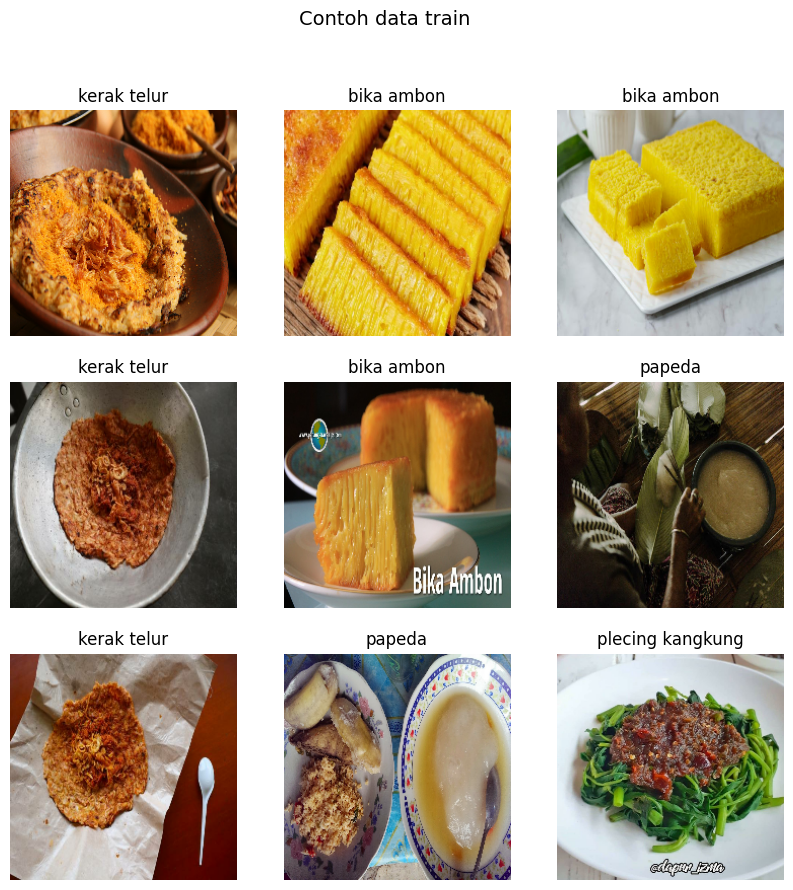

In [145]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):  # sebelum normalisasi biar warnanya asli
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = labels[i].numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Contoh data train", fontsize=14)
plt.show()

In [146]:
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=IMG_SIZE + (3,)),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Block 4 (opsional, boleh hapus kalau device-mu lambat)
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

d:\Projek-UAS-PMDPM_A_KERAS\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,234,756 (50.49 MB)

 Trainable params: 13,234,756 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [147]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # karena label integer
    metrics=['accuracy']
)

In [148]:
history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2863 - loss: 2.1162 - val_accuracy: 0.2414 - val_loss: 1.3726
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2780 - loss: 1.3744 - val_accuracy: 0.3103 - val_loss: 1.3350
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3568 - loss: 1.3298 - val_accuracy: 0.6897 - val_loss: 1.1988
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5892 - loss: 1.0888 - val_accuracy: 0.6207 - val_loss: 0.8408
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6017 - loss: 0.9970 - val_accuracy: 0.7931 - val_loss: 0.7017
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6390 - loss: 0.7970 - val_accuracy: 0.6552 - val_loss: 0.8073
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7593 - loss: 0.6710 - val_accuracy: 0.8621 - val_loss: 0.5564
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7635 - loss: 0.5657 - val_accuracy: 0.7931 - val_loss: 0.5170
Epoch 9/10
4/4 ━

In [149]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

history_df = pd.DataFrame({
    "epoch": list(epochs_range),
    "train_accuracy": acc,
    "val_accuracy": val_acc,
    "train_loss": loss,
    "val_loss": val_loss
})
history_df

,epoch,train_accuracy,val_accuracy,train_loss,val_loss
0,1,0.286307,0.241379,2.116236,1.372562
1,2,0.278008,0.310345,1.374376,1.335013
2,3,0.356846,0.689655,1.329800,1.198760
3,4,0.589212,0.620690,1.088823,0.840773
4,5,0.601660,0.793103,0.996997,0.701688
5,6,0.639004,0.655172,0.796975,0.807278
6,7,0.759336,0.862069,0.671028,0.556403
7,8,0.763485,0.793103,0.565723,0.516970
8,9,0.834025,0.827586,0.459695,0.410170
9,10,0.883817,0.862069,0.346628,0.367327


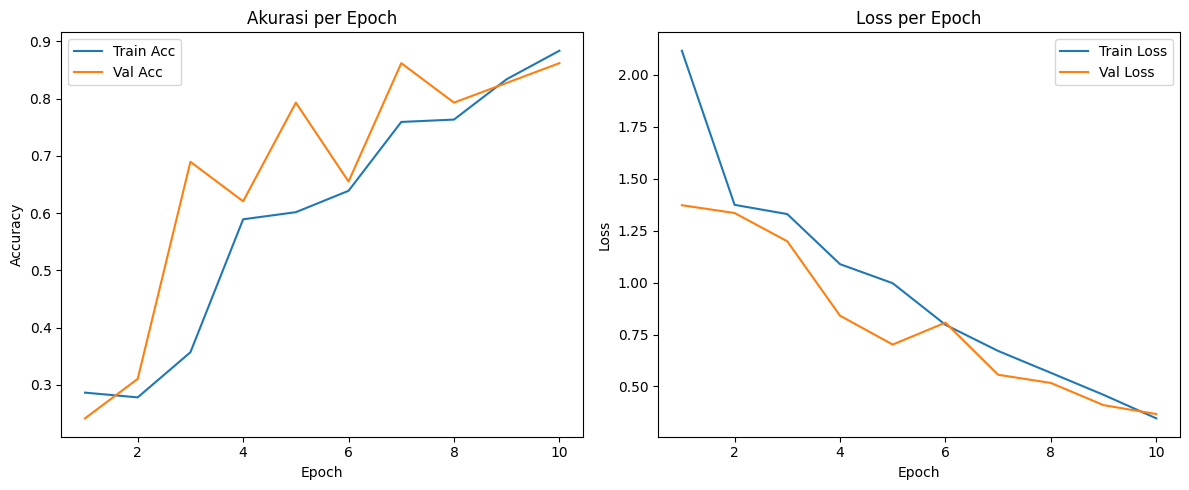

In [150]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [151]:
test_ds_fresh = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

def prep_eval_only(ds):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

test_eval_ds = prep_eval_only(test_ds_fresh)

Found 32 files belonging to 4 classes.


In [152]:
test_loss, test_acc = model.evaluate(test_eval_ds)
print("Test Loss :", test_loss)
print("Test Acc  :", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8125 - loss: 0.5629
Test Loss : 0.5629053115844727
Test Acc  : 0.8125


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Classification Report:
                  precision    recall  f1-score   support

      bika ambon       0.73      1.00      0.84         8
     kerak telur       0.80      0.50      0.62         8
          papeda       0.86      0.75      0.80         8
plecing kangkung       0.89      1.00      0.94         8

        accuracy                           0.81        32
       macro avg       0.82      0.81      0.80        32
    weighted avg       0.82      0.81      0.80        32



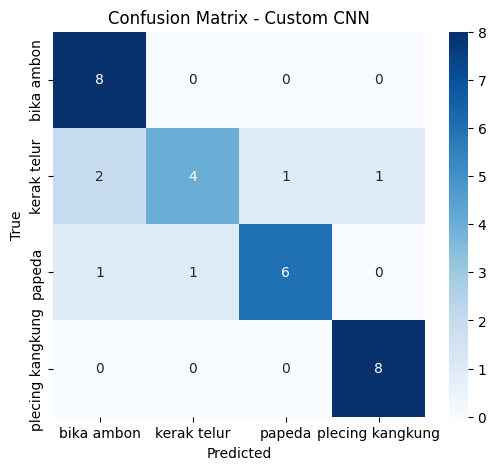

In [153]:
y_true = []
y_pred = []

for images, labels in test_eval_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


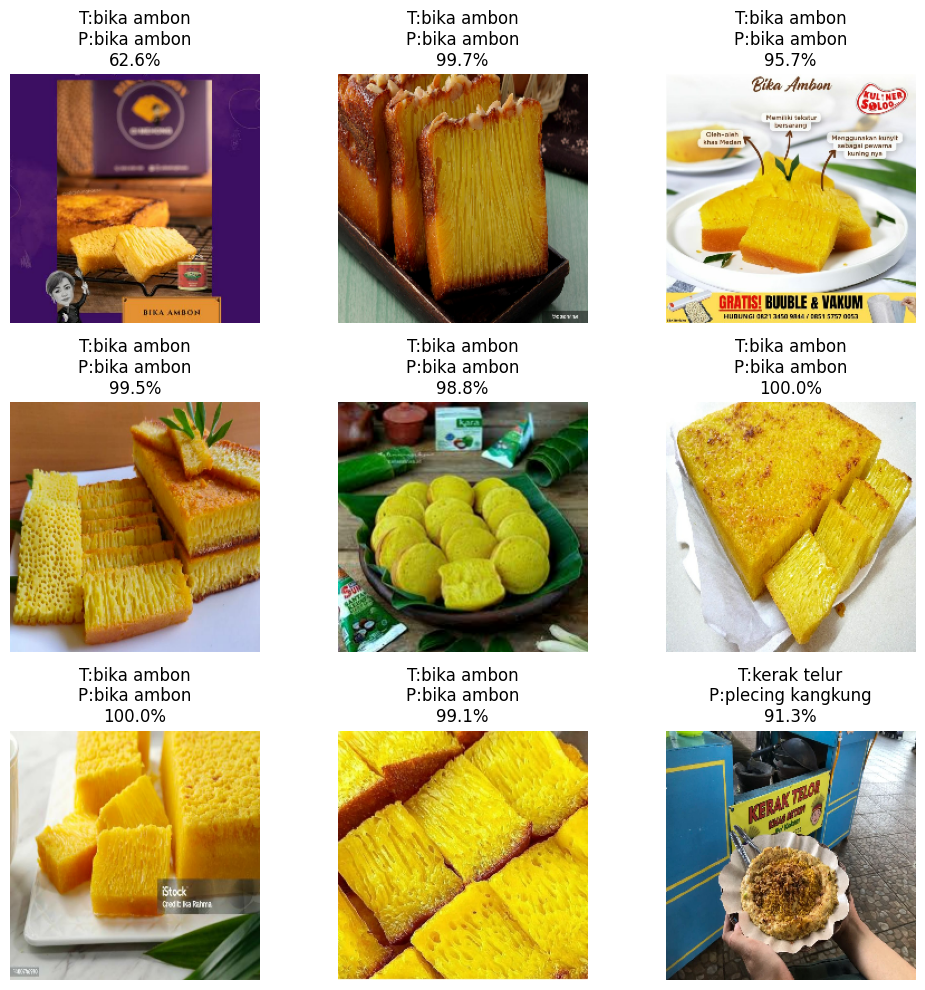

In [158]:
for images, labels in test_ds.take(1):  # pakai versi non-normalized hanya untuk tampilkan gambar asli
    imgs_uint8 = images.numpy().astype("uint8")
    probs = model.predict(images / 255.0)
    preds = np.argmax(probs, axis=1)

    plt.figure(figsize=(10,10))
    for i in range(min(9, len(imgs_uint8))):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs_uint8[i])
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[preds[i]]
        conf = np.max(probs[i]) * 100
        plt.title(f"T:{true_label}\nP:{pred_label}\n{conf:.1f}%")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [155]:
os.makedirs("../models", exist_ok=True)
save_path = "../models/BestModel_CustomCNN_KERAS.h5"  # ganti KelompokX sesuai kelompok kamu
model.save(save_path)
print("Model disimpan di:", save_path)


Model disimpan di: ../models/BestModel_CustomCNN_KERAS.h5
